### Indroduction
#### This notebook consists code for the Neural Style Transfer using pre-trained CNN classifier on Video data to produce stylized video 

In [44]:
#Necessary Packages
from __future__ import print_function, division
#from __future__ import print_function, division
from builtins import range, input
from keras.preprocessing import image   # for preprocessing the images
from builtins import range,input
from datetime import datetime
import scipy
import cv2    # for capturing videos
import math    # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils, to_categorical
from skimage.transform import resize   # for resizing images
import os
import tqdm
from tqdm import tqdm,tqdm_pandas
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras import applications,models, losses,optimizers
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_last')
import cv2
from glob import glob
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import tqdm
import cv2
from keras import applications
from keras.models import Model
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D,LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.metrics import categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
import numpy as np
import keras.backend as K
import scipy as sp
from scipy.spatial import distance
from PIL import Image
from keras.preprocessing import image
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from hyperas.distributions import choice, uniform #conditional
import hyperopt
from sklearn.model_selection import train_test_split
from keras.utils import Sequence, to_categorical
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, 
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from os import listdir
from pickle import dump
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,LSTM,LSTMCell
from keras.layers.merge import add
from keras.models import Model
from keras.utils import plot_model
from nltk.translate.bleu_score import corpus_bleu
from keras.models import load_model
from skimage.io import imread, imshow, imread_collection, concatenate_images
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

### Helper function for preprocessing content and style image before feed to VGG-16. We need to make sure the shape will be  (224,224),as per VGG-16 standard input format.

In [59]:
def load_preprocess_img(p,shape = None):
    Img = image.load_img(p, target_size=shape)
    X = image.img_to_array(Img)
    X = np.expand_dims(X,axis=0)    
    X = preprocess_input(X)
    return X

def preprocess_img(frame,shape = None):
    X = np.expand_dims(frame,axis=0)    
    X = preprocess_input(X.astype(('float64')))
    return X
    

#Loading style image
    
style_img = load_preprocess_img(p = "C:\\Users\\Feng Peng\\Downloads\\Neural-Style-Transfer-on-video-data-master\\Style_Image.jpg", shape=(224,224))
batch_shape = style_img.shape
shape = style_img.shape[1:]
shape

(224, 224, 3)

### Some helper functions:

#### a) vgg_avg_pooling customizes keras standard VGG16. Here we want to account for features across the entire image so get rid of the maxpool which throws away information

#### b) vgg_cutoff freezes the output(activation map)layer of earlier defined vgg_avg_pool model.there are 13 convolutions in total we can pick any of deeper layer as the "output" of our content model

#### c) gram_matrix defines calculation of Gram matrix for network feature maps

#### d) After gram_matrix calculation we will use style_loss function to total style loss of the style network.

#### e) unpreprocess and f) scale(optional) are to restore/modify the image pixel values generated from VGG-16

In [60]:
shape = (224,224,3)

#Content model define
def vgg_avg_pooling(shape):
    vgg = VGG16(input_shape=shape,weights='imagenet',include_top=False)
    model = Sequential()
    for layer in vgg.layers:
        if layer.__class__ == MaxPooling2D:
        # replace it with average pooling    
            model.add(AveragePooling2D())
        else:
            model.add(layer)
    return model   

def vgg_cutoff(shape,num_conv):
    if num_conv<1|num_conv>13:
        print('Error layer must be with in [1,13]')
    model = vgg_avg_pooling(shape)
    new_model = Sequential()
    n=0
    for layer in model.layers:
        new_model.add(layer)
        if layer.__class__ == Conv2D:
            n+=1
        if n >= num_conv:
            break
    return new_model

#Style loss comutation graph

def gram_matrix(img):
    # input is (H, W, C) (C = # feature maps)
    # we first need to convert it to (C, H*W)
    X = K.batch_flatten(K.permute_dimensions(img,(2,0,1)))
    # now, calculate the gram matrix
    # gram = XX^T / N
    gram_mat = K.dot(X,K.transpose(X))/img.get_shape().num_elements()
    return gram_mat 

def style_loss(y,t):
    return K.mean(K.square(gram_matrix(y)-gram_matrix(t)))

def unpreprocess(img):
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 126.68
    img = img[..., ::-1]
    return img

def scale(x):
    x = x-x.min()
    x=x/x.max()
    return x

#### This code block describes network and necessary computation for style image.We don't apply vgg_cutoff function here as the idea is to form a multi-output model combining shallow and deep conv layers to calculate style loss for style representation.

In [62]:
#loading,processing and defining multi_output_model and style loss computation of style image

#Style image load and VGG model load.
path = "C:\\Users\\Feng Peng\\Downloads\\Neural-Style-Transfer-on-video-data-master\\Style_Image.jpg"
img = image.load_img(path)
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)    
x = preprocess_input(x)
    #shape
batch_shape = x.shape
shape = x.shape[1:]
vgg = vgg_avg_pooling(shape)

#Define multi-output model
symb_conv_outputs = [layer.get_output_at(1) for layer in vgg.layers if layer.name.endswith('conv1')]
multi_output_model = Model(vgg.input, symb_conv_outputs)
symb_layer_out = [K.variable(y) for y in multi_output_model.predict(x)]

#Conv layer weight matrix
weights = [0.2,0.4,0.3,0.5,0.2]    
loss=0
#Total style loss
for symb,actual,w in zip(symb_conv_outputs,symb_layer_out,weights):
    loss += w * style_loss(symb[0],actual[0])
    
#gradients which are needed by the optimizer    
grad = K.gradients(loss,multi_output_model.input)
get_loss_grad = K.Function(inputs=[multi_output_model.input], outputs=[loss] + grad)

#Scipy's minimizer function(fmin_l_bfgs_b) allows us to pass back function value f(x) and 
#its gradient f'(x), which we calculated in earlier step. 
#However, we need to unroll the input to minimizer function in1-D array format and both loss and gradient must be np.float64.

def get_loss_grad_wrapper(x_vec):
    l,g = get_loss_grad([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)    

42549248/58889256 [====================>.........] - ETA: 43:2 - ETA: 32:3 - ETA: 32:4 - ETA: 32:3 - ETA: 28:0 - ETA: 26:3 - ETA: 24:3 - ETA: 23:2 - ETA: 22:3 - ETA: 21:3 - ETA: 19:3 - ETA: 18:1 - ETA: 17:3 - ETA: 16:4 - ETA: 16:1 - ETA: 15:5 - ETA: 15:1 - ETA: 13:2 - ETA: 13:1 - ETA: 12:1 - ETA: 12:1 - ETA: 11:2 - ETA: 11:2 - ETA: 10:1 - ETA: 9:5 - ETA: 9: - ETA: 9: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 7: - ETA: 8: - ETA: 7: - ETA: 7: - ETA: 6: - ETA: 7: - ETA: 6: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: 

58892288/58889256 [==============================] - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 28 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25

### L-BFGS optimizer to minimize overall network loss. Here we directly feed our wrapper function to calculate loss and gradient in each iteration. 

In [63]:
#Function to minimize loss
def min_loss(fn,epochs,batch_shape):
    t0 = datetime.now()
    losses = []
    x = np.random.randn(np.prod(batch_shape))
    for i in range(epochs):
        x, l, _ = scipy.optimize.fmin_l_bfgs_b(func=fn,x0=x,maxfun=20)
    # bounds=[[-127, 127]]*len(x.flatten())
    #x = np.clip(x, -127, 127)
    # print("min:", x.min(), "max:", x.max())
        print("iter=%s, loss=%s" % (i, l))
        losses.append(l)
    print("duration:", datetime.now() - t0)
    plt.plot(losses)
    plt.show()

    newimg = x.reshape(*batch_shape)
    final_img = unpreprocess(newimg)
    return final_img[0]

### Put together every thing in a for loop extracting image frame and iterating individual image frame through the NST network and saving stylized images.  

iter=0, loss=977.2409057617188
iter=1, loss=402.4819641113281
iter=2, loss=281.8101501464844
iter=3, loss=224.72210693359375
iter=4, loss=192.94976806640625
iter=5, loss=171.97576904296875
iter=6, loss=158.52224731445312
iter=7, loss=147.1786651611328
iter=8, loss=138.38067626953125
iter=9, loss=131.6375732421875
iter=10, loss=126.01823425292969
iter=11, loss=121.43138122558594
iter=12, loss=117.60098266601562
iter=13, loss=114.25483703613281
iter=14, loss=111.50043487548828
iter=15, loss=109.04405212402344
iter=16, loss=106.92277526855469
iter=17, loss=105.046875
iter=18, loss=103.38123321533203
iter=19, loss=101.86135864257812
iter=20, loss=100.47626495361328
iter=21, loss=99.18834686279297
iter=22, loss=97.99813842773438
iter=23, loss=96.89779663085938
iter=24, loss=95.8643569946289
iter=25, loss=94.93994140625
iter=26, loss=94.06364440917969
iter=27, loss=93.23709106445312
iter=28, loss=92.49111938476562
iter=29, loss=91.79930114746094
duration: 0:08:55.207242


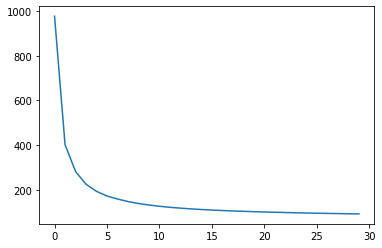

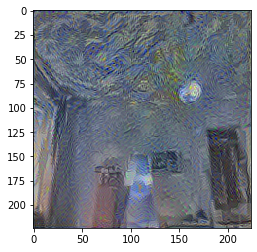

iter=0, loss=889.0276489257812
iter=1, loss=388.4057922363281
iter=2, loss=271.25994873046875
iter=3, loss=220.48870849609375
iter=4, loss=191.98072814941406
iter=5, loss=172.4993438720703
iter=6, loss=159.00558471679688
iter=7, loss=148.26214599609375
iter=8, loss=139.45840454101562
iter=9, loss=132.8654022216797
iter=10, loss=127.76554107666016
iter=11, loss=123.07304382324219
iter=12, loss=118.66387939453125
iter=13, loss=114.88361358642578
iter=14, loss=111.9919662475586
iter=15, loss=109.61181640625
iter=16, loss=107.42288970947266
iter=17, loss=105.4760971069336
iter=18, loss=103.68965911865234
iter=19, loss=102.21524047851562
iter=20, loss=100.85990142822266
iter=21, loss=99.54619598388672
iter=22, loss=98.33572387695312
iter=23, loss=97.17433166503906
iter=24, loss=96.08541870117188
iter=25, loss=95.09019470214844
iter=26, loss=94.19635009765625
iter=27, loss=93.35099792480469
iter=28, loss=92.567138671875
iter=29, loss=91.81578826904297
duration: 0:08:57.119915


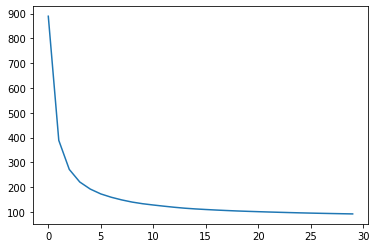

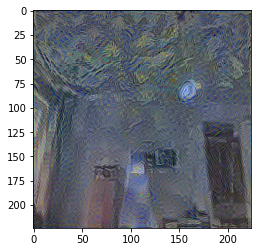

iter=0, loss=720.9077758789062
iter=1, loss=363.1790771484375
iter=2, loss=276.9703674316406
iter=3, loss=232.7085723876953
iter=4, loss=205.8677215576172
iter=5, loss=186.63009643554688
iter=6, loss=170.66168212890625
iter=7, loss=158.571044921875
iter=8, loss=148.41940307617188
iter=9, loss=141.35137939453125
iter=10, loss=136.17251586914062
iter=11, loss=131.5948944091797
iter=12, loss=127.76586151123047
iter=13, loss=124.24063110351562
iter=14, loss=121.04850769042969
iter=15, loss=118.00670623779297
iter=16, loss=115.4039077758789
iter=17, loss=113.10016632080078
iter=18, loss=111.04066467285156
iter=19, loss=109.15745544433594


In [ ]:
import cv2
import numpy as np
 
# Create a VideoCapture object
batch_shape = style_img.shape
shape = style_img.shape[1:]
cap = cv2.VideoCapture("C:\\Users\\Feng Peng\\Downloads\\Neural-Style-Transfer-on-video-data-master\\input_video.avi")
frame_width = int(cap.get(3))
frame_height = int(cap.get(4)) 
# Check if camera opened successfully
if (cap.isOpened() == False): 
    print("Unable to read camera feed")
 
# Default resolutions of the frame are obtained.The default resolutions are system dependent.
# We convert the resolutions from float to integer.
 
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
out = cv2.VideoWriter("C:\\Users\\Feng Peng\\Downloads\\Neural-Style-Transfer-on-video-data-master\\ouput2.avi",cv2.VideoWriter_fourcc(*'MJPG'),20.0,(224,224))
count = 0 
while(True):
    ret, frame = cap.read()
    frame = cv2.resize(frame,(224,224))
    X = preprocess_img(frame)
    vgg = vgg_avg_pooling(shape=shape)
    content_model = Model(vgg.input,vgg.layers[13].get_output_at(0))
    content_target = content_model.predict(X)
    symb_conv_outputs = [layer.get_output_at(0) for layer in vgg.layers if layer.name.endswith('conv1')]
    multi_output_model = Model(vgg.input, symb_conv_outputs)
    symb_layer_out = [K.variable(y) for y in multi_output_model.predict(style_img)]
    weights = [0.2,0.4,0.3,0.5,0.2]
    
    loss=K.mean(K.square(content_model.output-content_target)) *4 
    for symb,actual,w in zip(symb_conv_outputs,symb_layer_out,weights):
        loss += 0.03 * w * style_loss(symb[0],actual[0])
    
    grad = K.gradients(loss,vgg.input)
    get_loss_grad = K.Function(inputs=[vgg.input], outputs=[loss] + grad)
    def get_loss_grad_wrapper(x_vec):
        l,g = get_loss_grad([x_vec.reshape(*batch_shape)])
        return l.astype(np.float64), g.flatten().astype(np.float64)
    final_img = min_loss(fn=get_loss_grad_wrapper,epochs=30,batch_shape=batch_shape)
    plt.imshow(scale(final_img))
    plt.show()
    
    
    #cv2.imshow('output',frame)
    #out.write(final_img)
    filename ="C:\\Users\\Feng Peng\\Downloads\\Neural-Style-Transfer-on-video-data-master\\stylized_images\\frame%d.jpg" % count;count+=1 
    cv2.imwrite(filename, final_img)
    #if cv2.waitKey(1) & 0xFF == ord('q'):
        #break
     
    # Write the frame into the file 'output.avi'
        
 
    # Display the resulting frame    
        
  # Break the loop
    #if k == 27:
    #    break 
 
# When everything done, release the video capture and video write objects
cap.release()
out.release()
cv2.destroyAllWindows()

#### The last step is to recombine/stitch the generated image frames to form stylized video. The video generated with some pause in between.There are a few online free converters(online-convert,Wondershare UniConverter etc.),which can make the video smoother.

In [ ]:
#Converting images to video clipping

image_folder = "C:\\Users\\Feng Peng\\Downloads\\Neural-Style-Transfer-on-video-data-master\\stylized_images"
video_name = "C:\\Users\\Feng Peng\\Downloads\\Neural-Style-Transfer-on-video-data-master\\ouput2.avi"

images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

## Further Improvement and Experiments:

### Following are a few strategies to improve the quality of the generated image:

#### 1) More Iterations: It is is more obvious that running the network for more iterations(approximately 1000)will reduce the overall loss and will create more clear blended images.

#### 2) Advanced CNN architecture: More often than not for NST application deeper neural networks with very advanced connection can capture high level(spatial) and detailed texture features more accurately. So it's worth trying with other superior pretrained networks like InceptionV4, GoogLeNet, Resnet-101 etc. However runtime of these networks is significantly high for NST application with thousands of iteration and require expensive computation infrastructure like powerful GPU stacks.

#### 3) Tweaking content and style loss weights: As an experiment, I tried with 4 and 0.03 as content and style loss weights respectively, mainly to focus on capturing content as much as possible(as I am running the network for only a few iterations). However, this might not be appropriate and the ideal way to find the optimal weights is through a grid search

#### 4) Tweaking layer weights for style loss: To maximize style feature capture we need to tweak weights in respective conv layers for controlling style loss computation to optimize the extraction of textures(finer textures at early layers and higher-level features at deeper layers). Again these are hyperparameters and grid search is the ideal option.